## 5. Gets and Multi-gets (90 pts)

In [1]:
%load_ext autoreload
%autoreload 2

from queries import query_mw as q_mw
from queries import query_client as q_client
from queries import query_rthist_mw as q_rthist_mw
from queries import query_rthist_client as q_rthist_client
from queries import weighted_stats
from queries import hist_stats
from queries import network as q_net

from plots.ctrl import generate, dashboard_nc, dashboard_mget, dashboard_time, export
from plots import tp, rt, utilization, queue, ilaw, sst

suite={
    "exp51":"re_exp5",
    "exp52":"re_exp5"
}

plt_output_folder = "result"

In [2]:
import matplotlib.pyplot as plt

def rt_decomposition(df_client, df_mw):
    
    key_col = ['workload', 'n_worker_per_mw', 'num_clients', 'multi_get_size', 'multi_get_behaviour']

    
    df = df_mw.set_index(key_col).join(df_client.set_index(key_col),lsuffix='_mw', rsuffix='_client')
    df = df.reset_index()

    df = df.rename(columns={'rt_rep_mean_mw':'rt_mw',
                            'rt_rep_mean_client':'rt_client',
                            'ntt_rep_mean':'ntt',
                            'qwt_rep_mean':'qwt',
                            'wtt_rep_mean':'wtt',
                            'tsst_rep_mean':'tsst',
                            'sst_rep_mean':'sst',
                            'sstmax_rep_mean':'sstmax',
                           })
    
    
    df = df[['workload', 'multi_get_size', 'multi_get_behaviour', 'n_worker_per_mw', 'num_clients', 'rt_client', 'rt_mw', 'ntt', 'qwt', 'wtt', 'tsst', 'sst', 'sstmax']]
    
    df['wtt'] = df['wtt']-df['tsst']
    df = df.round(2)
    df['rt_sum'] = df.apply(lambda row: row['ntt'] + row['qwt'] + row ['wtt'] + row['sst'],axis=1)
    df['rt_sum_max'] = df.apply(lambda row: row['ntt'] + row['qwt'] + row ['wtt'] + row['sstmax'],axis=1)
    df['rt_sum_total'] = df.apply(lambda row: row['ntt'] + row['qwt'] + row ['wtt'] + row['tsst'],axis=1)
    
    df['diff_rt'] = df['rt_mw']-df['rt_sum']
    df['diffmax_rt'] = df['rt_mw']-df['rt_sum_max']
    df['difftotal_rt'] = df['rt_mw']-df['rt_sum_total']
    
    df = df.round(2)

    return df

### 5.1 Sharded-Case and 5.2 Non-Sharded Case

In [3]:
df_exp51_mw = q_mw.load_df(suite=suite["exp51"], exp="exp51")
df_exp51_mw.loc[df_exp51_mw.op_type == 'get' , "op_type"] = "mget"
df_exp51_mw['client_thinktime'] = df_exp51_mw.apply(lambda row: df_exp51_mw[(df_exp51_mw['multi_get_size']==row['multi_get_size'])&(df_exp51_mw['op_type']=='set')].loc[:,'rt_rep_mean'].values[0], axis=1)

df_exp52_mw = q_mw.load_df(suite=suite["exp52"], exp="exp52")
df_exp52_mw.loc[df_exp52_mw.op_type == 'get' , "op_type"] = "mget"
df_exp52_mw['client_thinktime'] = df_exp51_mw.apply(lambda row: df_exp52_mw[(df_exp52_mw['multi_get_size']==row['multi_get_size'])&(df_exp52_mw['op_type']=='set')].loc[:,'rt_rep_mean'].values[0], axis=1)

df_exp51_client = q_client.load_df(suite=suite["exp51"], exp="exp51")
df_exp51_client['throughput_rep_mean'] = df_exp51_client['throughputget_rep_mean']
df_exp51_client['throughput_rep_std'] = df_exp51_client['throughputget_rep_std']
df_exp51_client['rt_rep_mean'] = df_exp51_client['rtget_rep_mean']
df_exp51_client['rt_rep_std'] = df_exp51_client['rtget_rep_std']
df_exp51_client['client_thinktime'] = df_exp51_client['rtset_rep_mean']
df_exp51_client['op_type'] = "mget"

df_exp52_client = q_client.load_df(suite=suite["exp52"], exp="exp52")
df_exp52_client['throughput_rep_mean'] = df_exp52_client['throughputget_rep_mean']
df_exp52_client['throughput_rep_std'] = df_exp52_client['throughputget_rep_std']
df_exp52_client['rt_rep_mean'] = df_exp52_client['rtget_rep_mean']
df_exp52_client['rt_rep_std'] = df_exp52_client['rtget_rep_std']
df_exp52_client['client_thinktime'] = df_exp52_client['rtset_rep_mean']
df_exp52_client['op_type'] = "mget"

export(df_exp51_mw, "w_8", exp_name="exp51", suffix="_mw")
export(df_exp51_client, "w_8", exp_name="exp51", suffix="_client")

export(df_exp52_mw, "w_8", exp_name="exp52", suffix="_mw")
export(df_exp52_client, "w_8", exp_name="exp52", suffix="_client")


Saved Data: ./../../data/exp51/w_8/processed_mw.log
Saved Data: ./../../data/exp51/w_8/processed_client.log
Saved Data: ./../../data/exp52/w_8/processed_mw.log
Saved Data: ./../../data/exp52/w_8/processed_client.log


#### Interactive Law Sanity Check

In [4]:
print("FOR INTERACTIVE LAW USES SET RESPONSE TIME AS CLIENT THINKING TIME")

df_piv, df = ilaw.interactive_law_mget_mix(df_client=df_exp51_client, df_mw=df_exp51_mw[df_exp51_mw['op_type']=="mget"])
display(df_piv)


table = ilaw.table_mget(df_piv, n_mget=4, desc="sharded")
print(table)

df_piv, df = ilaw.interactive_law_mget_mix(df_client=df_exp52_client, df_mw=df_exp52_mw[df_exp52_mw['op_type']=="mget"])
display(df_piv)

table = ilaw.table_mget(df_piv, n_mget=4, desc="non-sharded")
print(table)

FOR INTERACTIVE LAW USES SET RESPONSE TIME AS CLIENT THINKING TIME


rt_ilaw_diff               
multi_get_size             1    3    6    9
n_worker_per_mw                            
8                       -0.1 -0.1  0.1  0.4

\begin{tabular}{|c|*{4}{r}|}
\cline{2-5}
\multicolumn{1}{c|}{} & \multicolumn{4}{c|}{multi-get size} \Tstrut\\
\multicolumn{1}{c|}{} & 1 & 3 & 6 & 9 \Tstrut\\
\hline
sharded & -0.1 & -0.1 & 0.1 & 0.4 \Tstrut\\
& \multicolumn{4}{c|}{in milliseconds} \\
\hline 
\end{tabular}


rt_ilaw_diff               
multi_get_size             1    3    6    9
n_worker_per_mw                            
8                       -0.1 -0.1  0.1  0.3

\begin{tabular}{|c|*{4}{r}|}
\cline{2-5}
\multicolumn{1}{c|}{} & \multicolumn{4}{c|}{multi-get size} \Tstrut\\
\multicolumn{1}{c|}{} & 1 & 3 & 6 & 9 \Tstrut\\
\hline
non-sharded & -0.1 & -0.1 & 0.1 & 0.3 \Tstrut\\
& \multicolumn{4}{c|}{in milliseconds} \\
\hline 
\end{tabular}


#### Network Bottleneck

In [5]:
read_bandwidth = df_exp51_mw['read_bandwidth_limit'].unique()[0]
read_bandwidth_bytes = read_bandwidth * 125000
value_size = 4096
print(f"Bandwidth: {read_bandwidth} MBit/sec")

print(f"Throughput Limit 1 Value: \t{int(read_bandwidth_bytes/value_size)} ops/sec")
print(f"Throughput Limit 3 Values: \t{int(read_bandwidth_bytes/(3*value_size))} ops/sec")
print(f"Throughput Limit 6 Values: \t{int(read_bandwidth_bytes/(6*value_size))} ops/sec")
print(f"Throughput Limit 9 Values: \t{int(read_bandwidth_bytes/(9*value_size))} ops/sec")

Bandwidth: 297.8 MBit/sec
Throughput Limit 1 Value: 	9088 ops/sec
Throughput Limit 3 Values: 	3029 ops/sec
Throughput Limit 6 Values: 	1514 ops/sec
Throughput Limit 9 Values: 	1009 ops/sec


#### Response Time Percentiles

Sharded: 


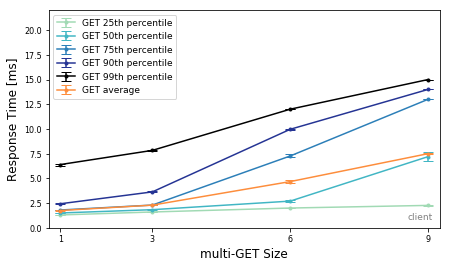

Non-Sharded: 


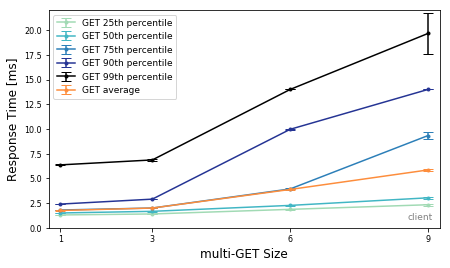

Saved Data: ./../../data/exp51/w_8/processed_p.log
Saved Data: ./../../data/exp52/w_8/processed_p.log


In [6]:
y_lim = 22

print("Sharded: ")
_,df_exp51_client_qtm = q_rthist_client.load_df(suite=suite["exp51"], exp="exp51")
df_exp51_client_qtm = df_exp51_client_qtm[df_exp51_client_qtm['op_type']=='get']

generate(rt.mget_perc, df_exp51_client_qtm, plt_output_folder, f"exp51_s_rt_mget_perc_client", opt=y_lim)

print("Non-Sharded: ")
_,df_exp52_client_qtm = q_rthist_client.load_df(suite=suite["exp52"], exp="exp52")
df_exp52_client_qtm = df_exp52_client_qtm[df_exp52_client_qtm['op_type']=='get']

generate(rt.mget_perc, df_exp52_client_qtm, plt_output_folder, f"exp52_ns_rt_mget_perc_client", opt=y_lim)

export(df_exp51_client_qtm, "w_8", exp_name="exp51", suffix="_p")
export(df_exp52_client_qtm, "w_8", exp_name="exp52", suffix="_p")

#### Throughput

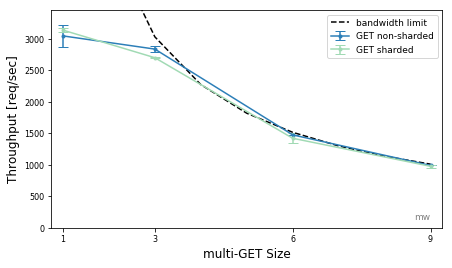

[1 3 6 9]
non-sharded
[3044. 8505. 8843. 8899.]
sharded
[3136. 8095. 8521. 8779.]
[9088. 9088. 9088. 9088.]


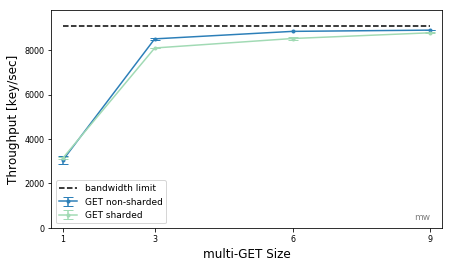

In [7]:
df51 = df_exp51_mw[df_exp51_mw['op_type']=='mget']
df52 = df_exp52_mw[df_exp52_mw['op_type']=='mget']

idx_col = ['n_worker_per_mw', 'num_clients', 'data_origin', 'op_type', 'multi_get_size']
df = df51.set_index(idx_col).join(df52.set_index(idx_col) , lsuffix='_sharded', rsuffix='_nonsharded').reset_index()
generate(tp.mget_mix, df, plt_output_folder, f"exp51exp52_tp_mget")

generate(tp.mget_mix_key, df)


#### Server Service Time

Sharded: 


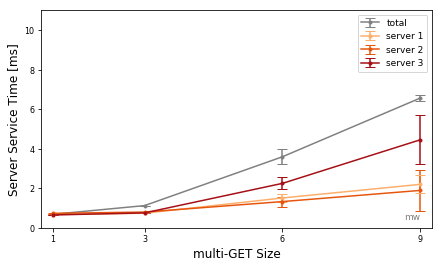

Non-Sharded: 


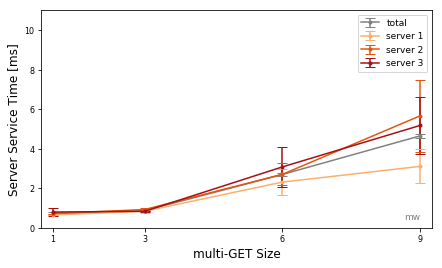

In [8]:
df51 = df_exp51_mw[df_exp51_mw['op_type']=='mget']
df52 = df_exp52_mw[df_exp52_mw['op_type']=='mget']

print("Sharded: ")
generate(sst.detail_mget, df51, plt_output_folder, "exp51_s_get_sst")

print("Non-Sharded: ")
generate(sst.detail_mget, df52, plt_output_folder, "exp52_ns_get_sst")

#### Response Time Decomposition

Sharded: 


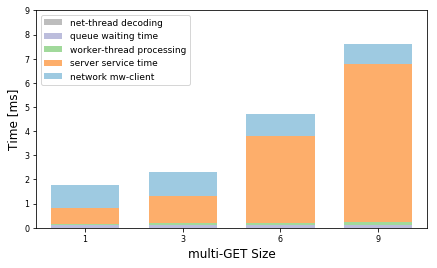

Non-Sharded: 


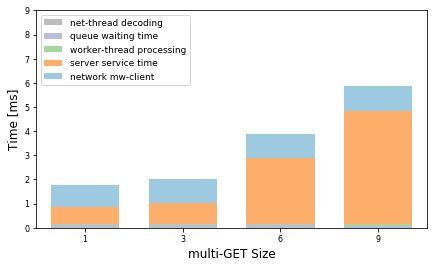

In [9]:
df51_mw = df_exp51_mw[df_exp51_mw['op_type']=='mget']
df52_mw = df_exp52_mw[df_exp52_mw['op_type']=='mget']

df51_client = df_exp51_client[df_exp51_client['op_type']=='mget']
df52_client = df_exp52_client[df_exp52_client['op_type']=='mget']


print("Sharded: ")
df = rt_decomposition(df_client=df51_client, df_mw=df51_mw)
generate(rt.component_mget, df, plt_output_folder, "exp51_s_rt_comp")

print("Non-Sharded: ")
df = rt_decomposition(df_client=df52_client, df_mw=df52_mw)
generate(rt.component_mget, df)

#### Load Balancing

In [10]:
df = df_exp51_mw.append(df_exp52_mw)
df = df[df['multi_get_size']==3]
df = df[['op_type', 'multi_get_behaviour', 'multi_get_size', 'sst0count_rep_mean', 'sst1count_rep_mean', 'sst2count_rep_mean']].round(0)

df = df.rename(columns={'sst0count_rep_mean':'Server 1 Request Count',
                            'sst1count_rep_mean':'Server 2 Request Count',
                            'sst2count_rep_mean':'Server 3 Request Count',
                           })

df['Total Server Request Count'] = df['Server 1 Request Count'] + df['Server 2 Request Count'] + df['Server 3 Request Count']

display(df)

,op_type,multi_get_behaviour,multi_get_size,Server 1 Request Count,Server 2 Request Count,Server 3 Request Count,Total Server Request Count
1,mget,sharded,3,13492.0,13492.0,13492.0,40476.0
5,set,sharded,3,13492.0,13492.0,13492.0,40476.0
1,mget,non-sharded,3,4725.0,4725.0,4725.0,14175.0
5,set,non-sharded,3,14175.0,14175.0,14175.0,42525.0


### 5.3 Histogram

- Both include cooldown and warmup phase in mw measurements
- Bin Max=15.0, all outlier put in last bucket
- Bin Size=0.21 determined using Freedman-Diaconis rule 2 * IQR(x) * n^(-1/3) on sharded mw and then kept constant
Sharded:
Sum Freq: MW=112945   Client=115174


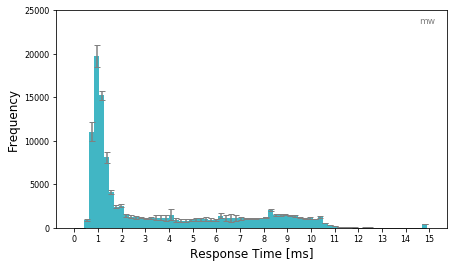

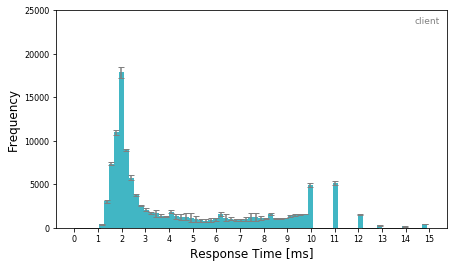

Non-Sharded:
Sum Freq: MW=118077   Client=119780


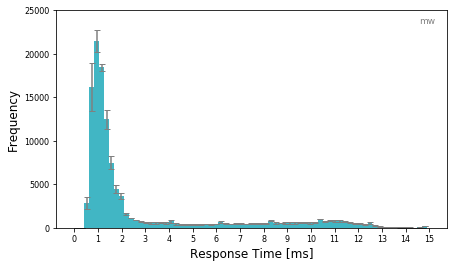

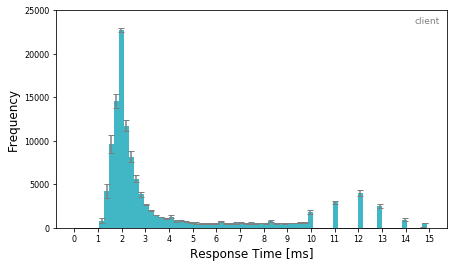

Saved Data: ./../../data/exp51/w_8/processed_hist_mw.log
Saved Data: ./../../data/exp51/w_8/processed_hist_client.log
Saved Data: ./../../data/exp52/w_8/processed_hist_mw.log
Saved Data: ./../../data/exp52/w_8/processed_hist_client.log


In [11]:
mget_size = 6
bin_size = 0.21
bin_max = 15.0

# TODO [nku] outlier handling
print("- Both include cooldown and warmup phase in mw measurements")
print(f"- Bin Max={bin_max}, all outlier put in last bucket")
print(f"- Bin Size={bin_size} determined using Freedman-Diaconis rule 2 * IQR(x) * n^(-1/3) on sharded mw and then kept constant")

df_rep_exp51_mw = q_rthist_mw.load_df_by_rep(suite=suite["exp51"], exp="exp51")
df_rep_exp51_client = q_rthist_client.load_df_by_rep(suite=suite["exp51"], exp="exp51")


df_rep_exp52_mw = q_rthist_mw.load_df_by_rep(suite=suite["exp52"], exp="exp52")
df_rep_exp52_client = q_rthist_client.load_df_by_rep(suite=suite["exp52"], exp="exp52")

df_rep_exp51_mw = df_rep_exp51_mw[(df_rep_exp51_mw['multi_get_size']==mget_size)&(df_rep_exp51_mw['op_type']=="get")]
df_rep_exp51_client = df_rep_exp51_client[(df_rep_exp51_client['multi_get_size']==mget_size)&(df_rep_exp51_client['op_type']=="get")]

df_rep_exp52_mw = df_rep_exp52_mw[(df_rep_exp52_mw['multi_get_size']==mget_size)&(df_rep_exp52_mw['op_type']=="get")]
df_rep_exp52_client = df_rep_exp52_client[(df_rep_exp52_client['multi_get_size']==mget_size)&(df_rep_exp52_client['op_type']=="get")]

df_hist_exp51_mw = hist_stats.aggregate_hist(df_rep_exp51_mw, bin_size=bin_size, bin_max=bin_max)
df_hist_exp51_client = hist_stats.aggregate_hist(df_rep_exp51_client, bin_size=bin_size, bin_max=bin_max)
df_hist_exp52_mw = hist_stats.aggregate_hist(df_rep_exp52_mw, bin_size=bin_size, bin_max=bin_max)
df_hist_exp52_client = hist_stats.aggregate_hist(df_rep_exp52_client, bin_size=bin_size, bin_max=bin_max)

y_lim = 1.1 * max(max(df_hist_exp51_mw['rt_freq_mean'].values), max(df_hist_exp51_client['rt_freq_mean'].values), max(df_hist_exp52_mw['rt_freq_mean'].values), max(df_hist_exp52_client['rt_freq_mean'].values))

print("Sharded:")
print(f"Sum Freq: MW={int(df_hist_exp51_mw['rt_freq_mean'].sum())}   Client={int(df_hist_exp51_client['rt_freq_mean'].sum())}")
generate(rt.mget_hist, df_hist_exp51_mw, plt_output_folder, f"exp51_s_mget6_hist_mw", opt=y_lim)
generate(rt.mget_hist, df_hist_exp51_client, plt_output_folder, f"exp51_s_mget6_hist_client", opt=y_lim)

print("Non-Sharded:")
print(f"Sum Freq: MW={int(df_hist_exp52_mw['rt_freq_mean'].sum())}   Client={int(df_hist_exp52_client['rt_freq_mean'].sum())}")
generate(rt.mget_hist, df_hist_exp52_mw, plt_output_folder, f"exp52_ns_mget6_hist_mw", opt=y_lim)
generate(rt.mget_hist, df_hist_exp52_client, plt_output_folder, f"exp52_ns_mget6_hist_client", opt=y_lim)

      
export(df_hist_exp51_mw, "w_8", exp_name="exp51", suffix="_hist_mw")
export(df_hist_exp51_client, "w_8", exp_name="exp51", suffix="_hist_client")
export(df_hist_exp52_mw, "w_8", exp_name="exp52", suffix="_hist_mw")
export(df_hist_exp52_client, "w_8", exp_name="exp52", suffix="_hist_client")

### 5.4 Summary